# Solution Planning

- OUTPUT:
    - The classification model will give the results and we need to compare in order to bring high results, such as:
        - 25% of the amount if the transaction is a frau and the model identify as a fraud;
        - 5% of the amount if the transaction is legit, but we classify as a fraud;
        - refund 100% of the amount for each transaction detected as legitimate, however the transaction is truly a fraud

- PROCESS:
    - Verify the amount of the data;
    - Verify if has NULL values and OUTLIERS;
    - Bring new variables to make a feature engineering in order to find relevant correlations;
    - If the dataset is unbalanced, try some balanced methods to bring better results;
    - Compare models and verify the cost-benefit of each one;
    - Do a improvement with hyperparameter fine-tunning (if it is necessary);
    - Bring monetary results of this action (loss or profit)

 - INPUT:
    - The CSV data from PaySim;
    - Verify the size of this data and made some upgrades, like save as parquet file ineach step of the CRISP-DM method

This is a sample of 1 row with headers explanation:

1,PAYMENT,1060.31,C429214117,1089.0,28.69,M1591654462,0.0,0.0,0,0

- **step** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

- **type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

- **amount** - amount of the transaction in local currency.

- **nameOrig** - customer who started the transaction

- **oldbalanceOrg** - initial balance before the transaction

- **newbalanceOrig** - new balance after the transaction

- **nameDest** - customer who is the recipient of the transaction

- **oldbalanceDest** - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

- **newbalanceDest** - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

- **isFraud** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

- **isFlaggedFraud** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
import joblib

from boruta import BorutaPy

from ydata_profiling import ProfileReport

from sklearn.utils import shuffle

from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score,recall_score,brier_score_loss, classification_report
from sklearn.metrics import roc_curve,plot_confusion_matrix,confusion_matrix,f1_score,cohen_kappa_score,auc,roc_auc_score
from sklearn.preprocessing import RobustScaler, MinMaxScaler,LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from imblearn.combine import SMOTETomek

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Helper Functions

In [3]:
def ml_metrics( model_name, y, yhat):
    precision = precision_score(y, yhat)
    recall = recall_score(y, yhat)
    accuracy = accuracy_score(y, yhat)
    f1_value = f1_score(y, yhat)
    cohen_kappa_value = cohen_kappa_score(y, yhat)
    return pd.DataFrame({'Model Name': model_name, 
                        'precision': precision,
                        'recall': recall,
                        'accuracy': accuracy,
                        'f1-score': f1_value,
                        'cohen-kappa': cohen_kappa_value}, index = [0])

In [4]:
def ml_cross_validation(model_name, model, k_fold, X, y):
    folder = StratifiedKFold(n_splits = k_fold)

    measures = pd.DataFrame()
    for train_index, test_index in folder.split(X, y):
        x_train_fold, x_test_fold = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train_fold, y_test_fold = y.iloc[train_index,:], y.iloc[test_index,:]

        model.fit(x_train_fold,y_train_fold.values.ravel())

        y_hat = model.predict(x_test_fold)

        measure = ml_metrics( model_name, y_test_fold, y_hat)
        measures = pd.concat( [ measures, measure], axis = 0, ignore_index = True)
    return measures

# Load Data

In [4]:
# path = '..\\data\\raw\\'

# df = pd.read_csv(path + 'PS_20174392719_1491204439457_log.csv')
# df.head()

# df.to_parquet('..\\data\\processed\\credit_card_transaction.parquet', index = False)

In [5]:
path = '..\\data\\processed\\'

In [ ]:
df = pd.read_parquet(path + 'credit_card_transaction.parquet')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0


## Data Dimension

In [ ]:
print('Number of rows: {} \n Number of columns: {}'.format(df.shape[0], df.shape[1]))

Number of rows: 6362620 
 Number of columns: 11


## Data Types

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [ ]:
df.sort_values(by=['isFlaggedFraud'], ascending = False)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6296014,671,TRANSFER,3441041.46,C917414431,3441041.46,3441041.46,C1082139865,0.00,0.00,1,1
6362460,730,TRANSFER,10000000.00,C2140038573,17316255.05,17316255.05,C1395467927,0.00,0.00,1,1
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.00,0.00,1,1
6362584,741,TRANSFER,5674547.89,C992223106,5674547.89,5674547.89,C1366804249,0.00,0.00,1,1
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.00,0.00,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2120869,183,CASH_IN,118980.42,C1325911476,1704431.57,1823411.99,C257232928,2001605.12,1882624.70,0,0
2120868,183,CASH_IN,203094.44,C24786701,1501337.12,1704431.57,C316761923,8095303.60,7892209.15,0,0
2120867,183,CASH_IN,174346.32,C1795889203,1326990.80,1501337.12,C547359094,276757.88,102411.55,0,0
2120866,183,CASH_IN,67507.70,C1035027223,1259483.10,1326990.80,C1730848226,94625.84,27118.13,0,0


## Check NA

In [ ]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

# Descriptive Statistics

In [ ]:
num_attributes = df.select_dtypes(include=['int64','float64'])
cat_attributes = df.select_dtypes(include=['object'])

## Numerical Attributes

In [ ]:
min_v = pd.DataFrame(num_attributes.apply( np.min )).T
max_v = pd.DataFrame(num_attributes.apply( np.max )).T
mean_v = pd.DataFrame(num_attributes.apply( np.mean )).T
median_v = pd.DataFrame(num_attributes.apply( np.median )).T
std_v = pd.DataFrame(num_attributes.apply( np.std )).T
skew_v = pd.DataFrame(num_attributes.apply( lambda x: x.skew() )).T
kurtosis_v = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T

results = pd.concat( [ min_v, max_v, mean_v, median_v, std_v, skew_v, kurtosis_v]).T.reset_index()
results.columns = ['attributes','min','max','mean','median','std','skew','kurtosis']
results

,attributes,min,max,mean,median,std,skew,kurtosis
0,step,1.00,743.00,243.40,239.00,142.33,0.38,0.33
1,amount,0.00,92445516.64,179861.90,74871.94,603858.18,30.99,1797.96
2,oldbalanceOrg,0.00,59585040.37,833883.10,14208.00,2888242.45,5.25,32.96
3,newbalanceOrig,0.00,49585040.37,855113.67,0.00,2924048.27,5.18,32.07
4,oldbalanceDest,0.00,356015889.35,1100701.67,132705.66,3399179.85,19.92,948.67
5,newbalanceDest,0.00,356179278.92,1224996.40,214661.44,3674128.65,19.35,862.16
6,isFraud,0.00,1.00,0.00,0.00,0.04,27.78,769.70
7,isFlaggedFraud,0.00,1.00,0.00,0.00,0.00,630.60,397659.06


In [ ]:
df_fraud = df.loc[df['isFraud'] == 1]
df_non_fraud = df.loc[df['isFraud'] == 0]

In [ ]:
q1 = np.log1p(df_fraud['amount'].quantile(.25))
q3 = np.log1p(df_fraud['amount'].quantile(.75))
iqr = q3 - q1
low_boundary = q1 - (1.5 * iqr)
high_boundary = q3 + (1.5 * iqr)
print('For fraudulent transactions we have these values for AMOUNT...\n LOW: {} and HIGH: {}'.format(low_boundary, high_boundary))

For fraudulent transactions we have these values for AMOUNT...
 LOW: 8.032541256509171 and HIGH: 17.952882196944806


In [ ]:
# fig, axes = plt.subplots(1,2,figsize=(16,8))

# sns.distplot(a = df_non_fraud['amount'], ax = axes[0]);
# sns.distplot(a =  np.log1p(df_non_fraud['amount']), ax = axes[1]);
# axes[0].set_title('Amount (RAW)');
# axes[1].set_title('Amount (LOG)');

In [ ]:
q1 = df_non_fraud['step'].quantile(.25)
q3 = df_non_fraud['step'].quantile(.75)
iqr = q3 - q1
low_boundary = q1 - (1.5 * iqr)
high_boundary = q3 + (1.5 * iqr)
print('For non-fraudulent transactions we have these values for STEP...\n LOW: {} and HIGH: {}'.format(low_boundary, high_boundary))

For non-fraudulent transactions we have these values for STEP...
 LOW: -111.0 and HIGH: 601.0


In [ ]:
df_non_fraud_no = df_non_fraud.loc[df_non_fraud['step'] < 601]
df_fraud_no = df_fraud.loc[~( df_fraud['amount'] < np.expm1( 8.032541256509171) ) ]

In [ ]:
df_no = pd.concat([df_non_fraud_no, df_fraud_no], axis = 0)

df_no = shuffle(df_no)

df_no.reset_index(drop=True, inplace=True)

In [ ]:
ratio_out = round(100 * (df.shape[0] - df_no.shape[0]) / df.shape[0], 2)
print('Ratio of outliers: {} %'.format(ratio_out))

Ratio of outliers: 1.6 %


In [ ]:
df_no.to_parquet('..\\data\\processed\\credit_card_transaction_without_outliers.parquet', index = False)

## Categorical Attributes

# Feature Engineering

In [ ]:
df1 = pd.read_parquet('..\\data\\processed\\credit_card_transaction_without_outliers.parquet')

Features to create:
- `transaction_direction`: (C2C,C2M,M2M,M2C)
- `hour`: equivalent to STEP
- `orig_type` (customer or machine)
- `dest_type` (customer or machine)
- `old_balance_orig_status` (zero or non zero)
- `new_balance_orig_status` (zero or non zero)
- `old_balance_dest_status` (zero or non zero)
- `new_balance_dest_status` (zero or non zero)
- `is_orig_old_balance_greater_new` (yes or no)
- `is_dest_old_balance_greater_new` (yes or no)
- `is_orig_equal_dest` (yes or no)


In [ ]:
df1.head(3)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,596,CASH_OUT,8825.82,C782444622,0.00,0.00,C1011515295,8042989.00,8250953.84,0,0
1,36,CASH_OUT,120510.31,C871280083,21857.00,0.00,C374774723,0.00,120510.31,0,0
2,522,PAYMENT,3652.68,C47507948,187.00,0.00,M1308980435,0.00,0.00,0,0


In [ ]:
# orig_type
df1['orig_type'] = 'customer'
df1.loc[df1['nameOrig'].str.contains('M'), 'orig_type'] = 'machine'

# dest_type
df1['dest_type'] = 'customer'
df1.loc[df1['nameDest'].str.contains('M'), 'dest_type'] = 'machine'

# old_balance_orig_status
df1['old_balance_orig_status'] = 'zero'
df1.loc[df1['oldbalanceOrg'] != 0, 'old_balance_orig_status'] = 'non zero'

# new_balance_orig_status
df1['new_balance_orig_status'] = 'zero'
df1.loc[df1['newbalanceOrig'] != 0, 'new_balance_orig_status'] = 'non zero'

# old_balance_dest_status
df1['old_balance_dest_status'] = 'zero'
df1.loc[df1['oldbalanceDest'] != 0, 'old_balance_dest_status'] = 'non zero'

# new_balance_dest_status
df1['new_balance_dest_status'] = 'zero'
df1.loc[df1['newbalanceDest'] != 0, 'new_balance_dest_status'] = 'non zero'

# is_orig_old_balance_greater_new
df1['is_orig_old_balance_greater_new'] = 'yes'
df1.loc[df1['newbalanceOrig'] < df1['oldbalanceOrg'], 'is_orig_old_balance_greater_new'] = 'no'

# is_dest_old_balance_greater_new
df1['is_dest_old_balance_greater_new'] = 'yes'
df1.loc[df1['newbalanceDest'] < df1['oldbalanceDest'], 'is_dest_old_balance_greater_new'] = 'no'

# transaction_direction
df1['transaction_direction'] = 'C2C'
df1.loc[(df1['orig_type'] == 'customer') & (df1['dest_type'] == 'machine'), 'transaction_direction'] = 'C2M'
df1.loc[(df1['orig_type'] == 'machine') & (df1['dest_type'] == 'customer'), 'transaction_direction'] = 'M2C'
df1.loc[(df1['orig_type'] == 'machine') & (df1['dest_type'] == 'machine'), 'transaction_direction'] = 'M2M'


# is_orig_equal_dest
for i in ['nameOrig','nameDest']:
    df1[i] = df1[i].astype(str).str.strip()
df1['is_orig_equal_dest'] = 'yes'
df1.loc[df1['nameOrig'] != df1['nameDest'], 'is_orig_equal_dest'] = 'no'

In [ ]:
# hour

# create a dataframe to refer the correct hour of the day
qty_iter = int((df1['step'].max() - df1['step'].min()) / 24)

rel_step_hour = pd.DataFrame()

list_hour_day = list(np.arange(24))
list_days = list(np.arange(24))

for i in range(qty_iter):
    list_hour_day = list_hour_day + list_days

rel_step_hour = pd.DataFrame(list_hour_day, columns = ['hour'])
rel_step_hour['step'] = np.arange(1,len(rel_step_hour) + 1)



print(df1.shape)

df1 = df1.merge(rel_step_hour,on = ['step'], how = 'inner')

print(df1.shape)

(6260531, 21)
(6260531, 22)


In [ ]:
# # proportion between the amount and oldBalance
# df['proportionBalance'] = round(100 * ((df['newbalanceOrig'] - df['oldbalanceOrg']) / df['oldbalanceOrg']), 2)
# df.replace([np.nan,np.inf,-np.inf], 0, inplace = True)
# df.head()

In [ ]:
df1.head(3)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,orig_type,dest_type,old_balance_orig_status,new_balance_orig_status,old_balance_dest_status,new_balance_dest_status,is_orig_old_balance_greater_new,is_dest_old_balance_greater_new,transaction_direction,is_orig_equal_dest,hour
0,596,CASH_OUT,8825.82,C782444622,0.00,0.00,C1011515295,8042989.00,8250953.84,0,0,customer,customer,zero,zero,non zero,non zero,yes,yes,C2C,no,19
1,596,PAYMENT,4302.92,C210770658,0.00,0.00,M2128364068,0.00,0.00,0,0,customer,machine,zero,zero,zero,zero,yes,yes,C2M,no,19
2,596,PAYMENT,6632.46,C1972074277,0.00,0.00,M5566948,0.00,0.00,0,0,customer,machine,zero,zero,zero,zero,yes,yes,C2M,no,19


In [ ]:
for i in ['isFlaggedFraud','orig_type','dest_type']:
    print(df1[i].value_counts())
    print('\n')

0    6260515
1         16
Name: isFlaggedFraud, dtype: int64


customer    6260531
Name: orig_type, dtype: int64


customer    4144177
machine     2116354
Name: dest_type, dtype: int64




In [ ]:
for i in ['old_balance_orig_status','new_balance_orig_status','old_balance_dest_status','new_balance_dest_status']:
    print(df1[i].value_counts())
    print('\n')

non zero    4184808
zero        2075723
Name: old_balance_orig_status, dtype: int64


zero        3555554
non zero    2704977
Name: new_balance_orig_status, dtype: int64


non zero    3602018
zero        2658513
Name: old_balance_dest_status, dtype: int64


non zero    3861417
zero        2399114
Name: new_balance_dest_status, dtype: int64




In [ ]:
for i in ['is_orig_old_balance_greater_new','is_dest_old_balance_greater_new','transaction_direction','is_orig_equal_dest']:
    print(df1[i].value_counts())
    print('\n')

yes    3437692
no     2822839
Name: is_orig_old_balance_greater_new, dtype: int64


yes    5042568
no     1217963
Name: is_dest_old_balance_greater_new, dtype: int64


C2C    4144177
C2M    2116354
Name: transaction_direction, dtype: int64


no    6260531
Name: is_orig_equal_dest, dtype: int64




## Hipothesis

> Transaction Type
1. Payment represent 50% of the total fraudulent transactions.
2. Transfer represent 50% of the total non fraudulent transactions.

> Transaction Direction
1. Customer to Merchant represent at least 50% of the total fraudulent transactions.
2. Customer to Customer represent at least 50% of the total non fraudulent transactions.

> Transaction Destination
1. Merchant destination represents 40% of the total fraudulent transactions.
2. Customer destination represents 40% of the total non fraudulent transactions.
3. Destination non zero new balance represents 50% of the total fraudulent transactions.

> Transaction Origin
1. Origin non zero old balance represents 80% of the total fraudulent transactions.
2. Origin zero new balance represents 40% of the total fraudulent transactions.

> Flagged as fraud
1. At least 95% of the total fraudulent transactions are flagged as fraud.
2. At least 20% of the total non fraudulent transactions are flagged as fraud.

# Data Filtering

# EDA

In [ ]:
df2 = df1.copy()

## Univariate Analysis

0   99.87
1    0.13
Name: isFraud, dtype: float64


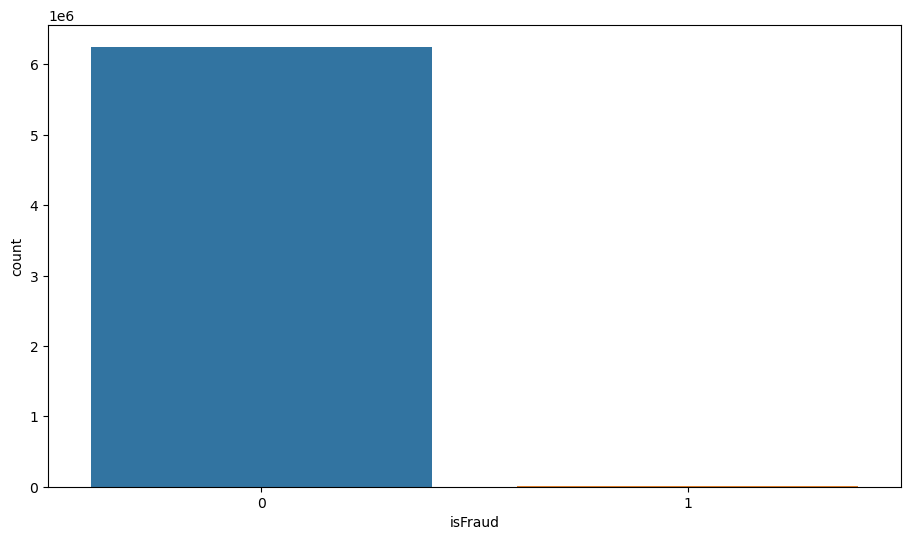

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(11,6))
print(df2['isFraud'].value_counts(normalize = True)*100)

sns.countplot(x= df2['isFraud'], ax = axes);

In [ ]:
# gets the numerical attributes
numerical_att = df2[['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig','oldbalanceDest', 'newbalanceDest']]

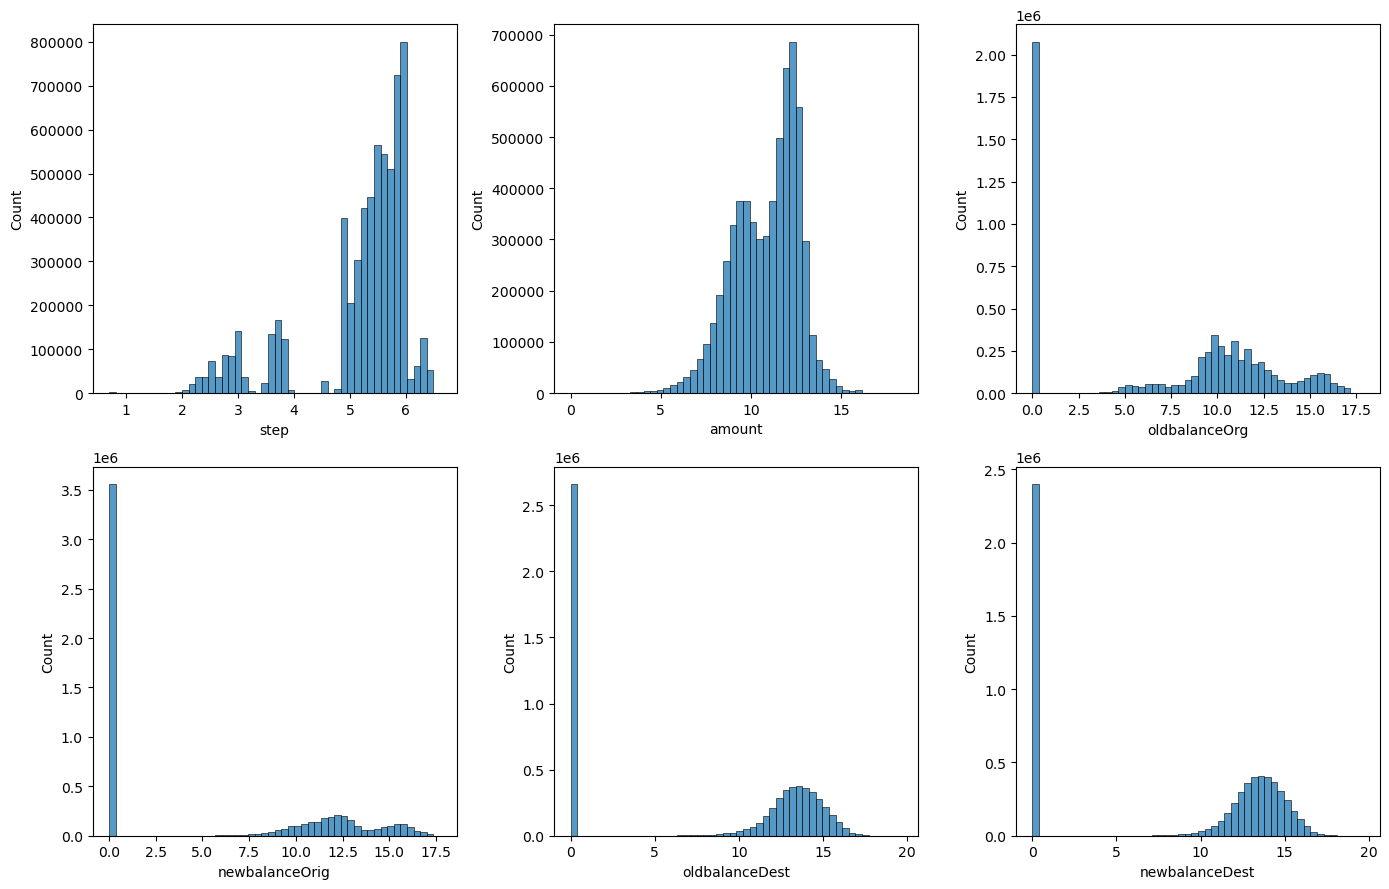

In [ ]:
# sets the plot size
plt.figure(figsize=(14,9))

# sets the initial plot position
n = 1

# iterate over the columns to plot
for column in numerical_att.columns:
    plt.subplot(2,3,n)
    _ = sns.histplot(x=np.log1p(numerical_att[column]), bins=50)
    n += 1

plt.tight_layout()

In [ ]:
# inverse log transform: amount
print(f'AMOUNT higher concentration: between {round(np.expm1(11), 2)} and {round(np.expm1(13), 2)}')

# inverse log transform: old_balance_orig
print(f'Origin old balance minor concentration: between {round(np.expm1(9), 2)} and {round(np.expm1(12), 2)}')

# inverse log transform: new_balance_orig
print(f'Origin new balance minor concentration: between {round(np.expm1(11.5), 2)} and {round(np.expm1(13), 2)}')

# inverse log transform: old_balance_dest
print(f'Destination old balance minor concentration: between {round(np.expm1(12.5), 2)} and {round(np.expm1(14.5), 2)}')

# inverse log transform: new_balance_dest
print(f'Destination new balance minor concentration: between {round(np.expm1(12.5), 2)} and {round(np.expm1(14.5), 2)}')

AMOUNT higher concentration: between 59873.14 and 442412.39
Origin old balance minor concentration: between 8102.08 and 162753.79
Origin new balance minor concentration: between 98714.77 and 442412.39
Destination old balance minor concentration: between 268336.29 and 1982758.26
Destination new balance minor concentration: between 268336.29 and 1982758.26


> Balance, such as Orig and Dest, is concentrated in ZERO;

> Amount is concentrated between 59,873.14 and 442,412.39

In [ ]:
# gets the category  attributes
cat_cols = ['type','isFlaggedFraud', 'orig_type', 'dest_type', 'old_balance_orig_status',
       'new_balance_orig_status', 'old_balance_dest_status',
       'new_balance_dest_status', 'is_orig_old_balance_greater_new',
       'is_dest_old_balance_greater_new', 'transaction_direction',
       'is_orig_equal_dest']
cat_att = df2[cat_cols]
len(cat_att.columns)

12

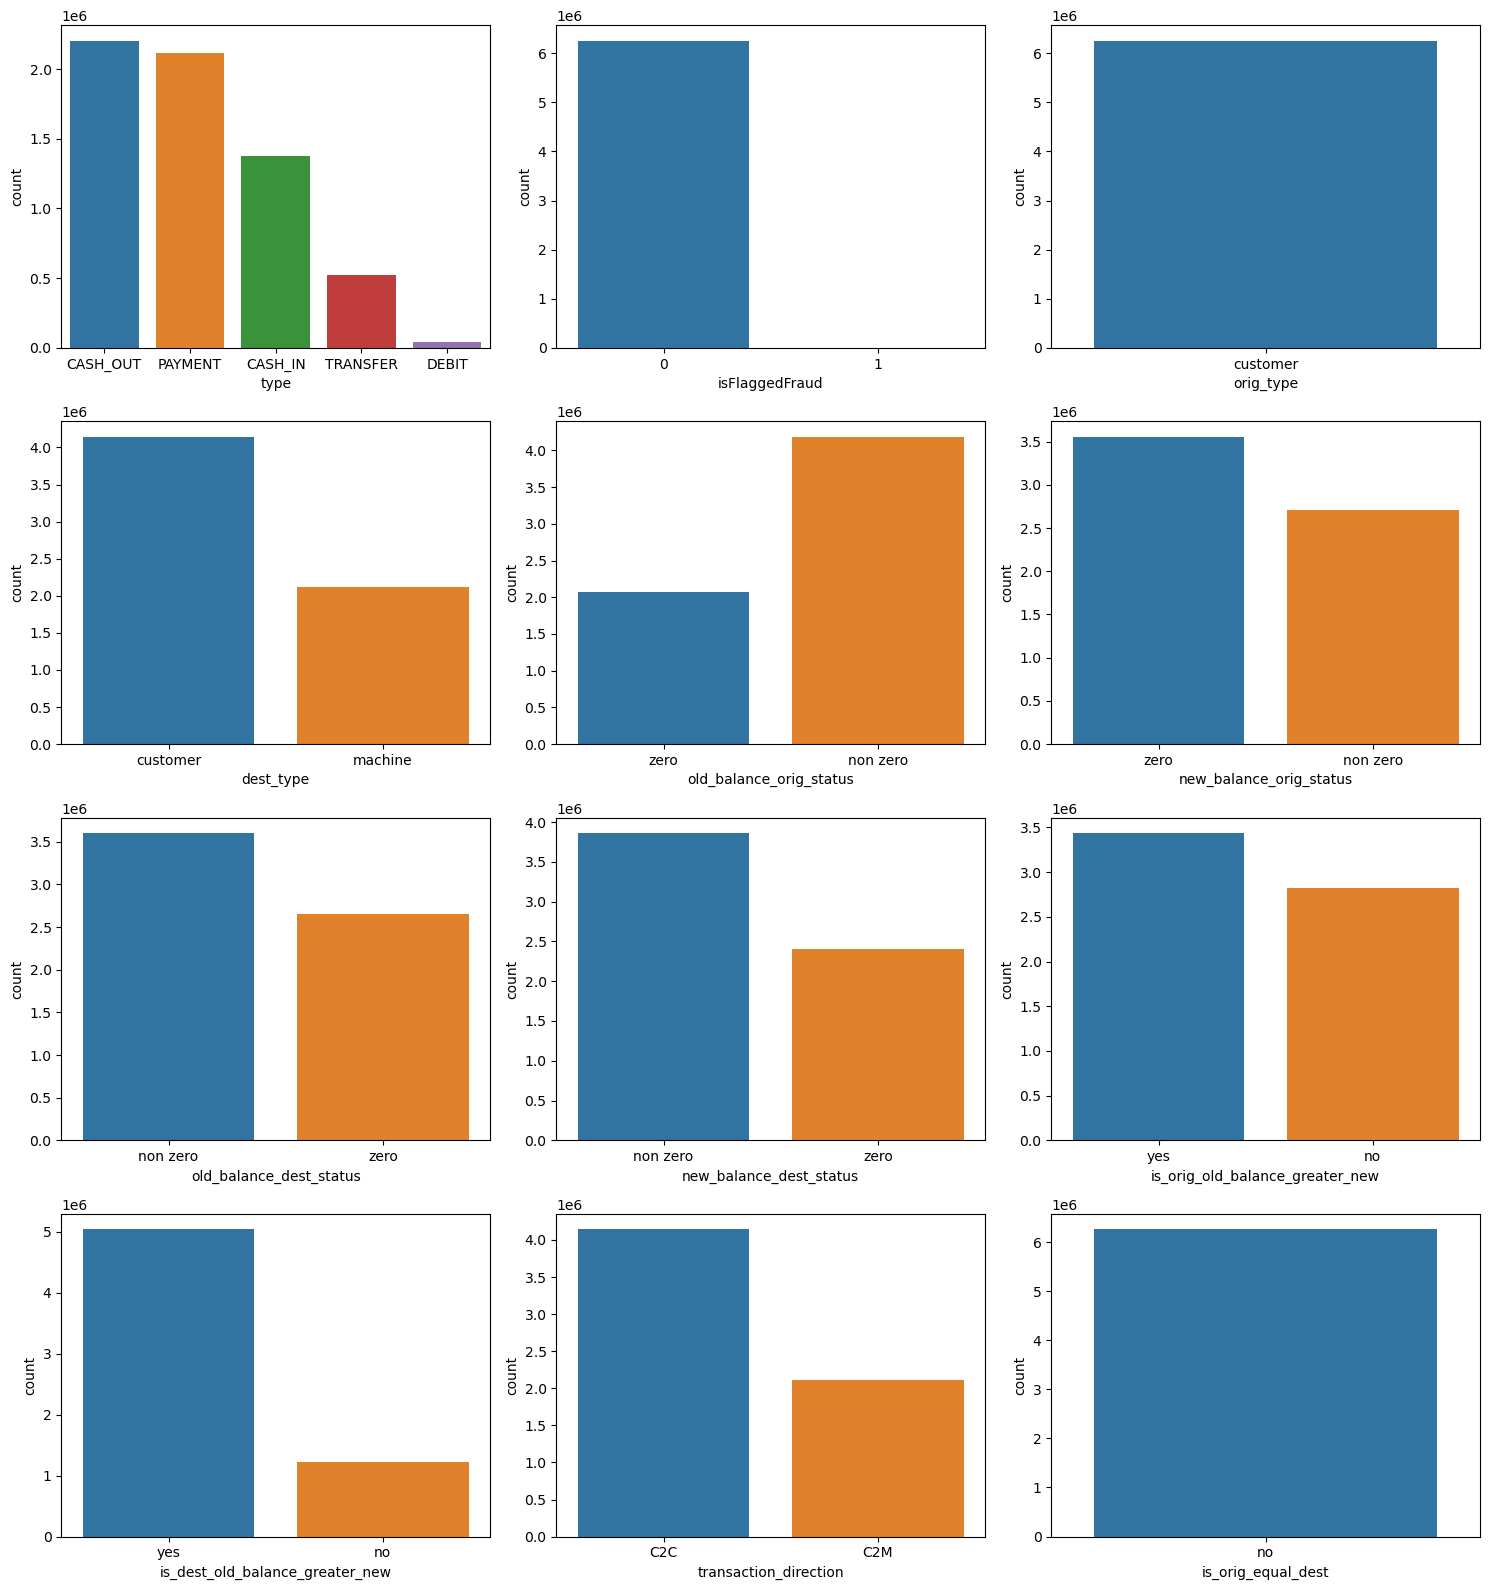

In [ ]:
# sets the plot size
plt.figure(figsize=(15,16))

# sets the initial plot position
n = 1

# iterate over the columns to plot
for column in cat_att.columns:
    plt.subplot(4,3,n)
    _ = sns.countplot(x=cat_att[column])
    n += 1

plt.tight_layout()

Key points:

- Cash-out and payment represent the major part of the total transactions.
- The great majority of the transactions are not flagged as fraud.
- There is only one type of origin: customer.
- There are more transactions whose destination is customer.
- The origin old balance status is non zero for the majority of transactions.
- There are more transactions whose the origin new balance status is zero.
- There are more transactions whose the destination old balance status is non zero.
- There are more transactions whose the destination new balance status is non zero.
- No transactions has the the same origin as destination.
- There are more transactions whose origin old balance is higher than the new.
- The destination old balance is higher than the new for the majority of the transctions.
- The transaction direction C2C is almost the double of C2M.

In [ ]:
num_orig_uq = len(df2['nameOrig'].unique())
num_dest_uq = len(df2['nameDest'].unique())

In [ ]:
ratio_orig_all = round(num_orig_uq / df_no.shape[0],3)
ratio_dest_all = round(num_dest_uq / df_no.shape[0],3)

print('Number of unique OrigName: {} and Proportion compared with all dataset: {}'.format(num_orig_uq,ratio_orig_all))
print('Number of unique DestName: {} and Proportion compared with all dataset: {}'.format(num_dest_uq,ratio_dest_all))

NameError: name 'df_no' is not defined

In [ ]:
# fig, axes = plt.subplots(4, 1, figsize=(16,20))

# sns.histplot(data = df1.loc[df1['type'] == 'PAYMENT'], x = 'amount', hue = 'isFraud', ax = axes[0], bins = 50);
# sns.histplot(data = df1.loc[df1['type'] == 'TRANSFER'], x = 'amount', hue = 'isFraud', ax = axes[1], bins = 50);
# sns.histplot(data = df1.loc[df1['type'] == 'CASH_IN'], x = 'amount', hue = 'isFraud', ax = axes[2], bins = 50);
# sns.histplot(data = df1.loc[df1['type'] == 'CASH_OUT'], x = 'amount', hue = 'isFraud', ax = axes[3], bins = 50);
# axes[0].set_title('PAYMENT');
# axes[1].set_title('TRANSFER');
# axes[2].set_title('CASH_IN');
# axes[3].set_title('CASH_OUT');
# plt.tight_layout()

In [ ]:
# fig, axes = plt.subplots(3, 1, figsize=(16,16))
# aux = df1.loc[ df1['type'].isin( ['TRANSFER','CASH_OUT'] ) ]

# sns.histplot(data = aux, x = 'amount', hue = 'isFraud', ax = axes[0], bins = 50);
# sns.histplot(data = aux.loc[aux['isFraud'] == 0 ], x='amount', hue = 'isFraud', ax = axes[1], bins = 50);
# sns.histplot(data = aux.loc[aux['isFraud'] == 1 ], x='amount', hue = 'isFraud', ax = axes[2], bins = 50);
# axes[0].set_title('Only - Transfer/CashOut');
# axes[1].set_title('isFraud = 0');
# axes[2].set_title('isFraud = 1');
# plt.tight_layout()

## Bivariate Analysis

In [ ]:
df_fraud = df2.loc[df2['isFraud'] == 1]
df_non_fraud = df2.loc[df2['isFraud'] == 0]

### H1. Payment represent 50% of the total fraudulent transactions.

CASH_OUT   0.50
TRANSFER   0.50
Name: type, dtype: float64


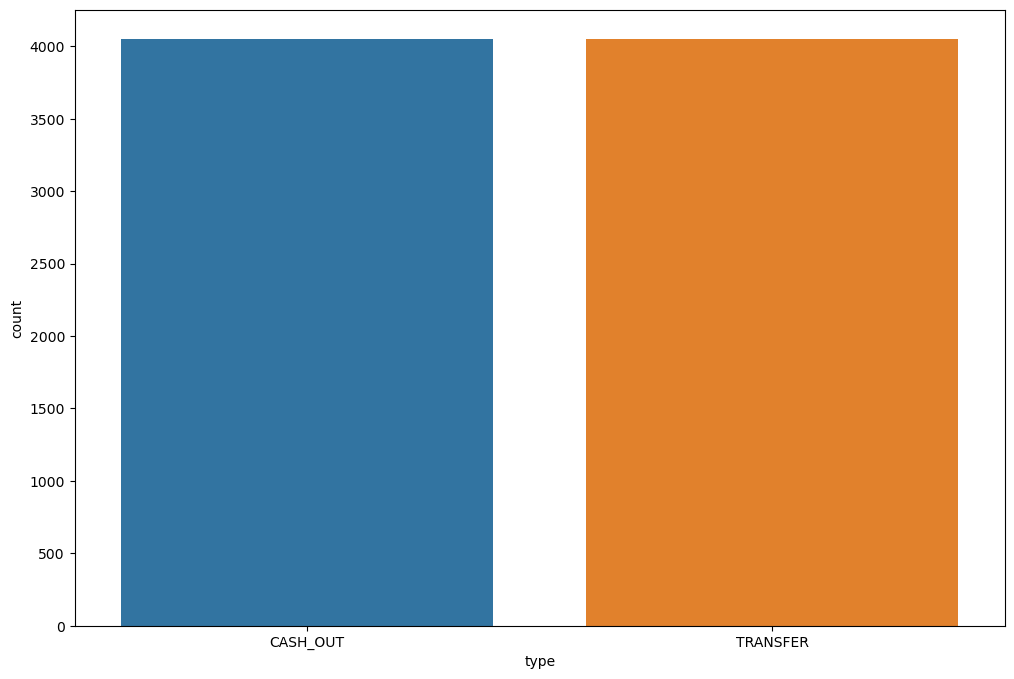

In [ ]:
plt.figure(figsize=(12,8))
print(df_fraud['type'].value_counts(normalize = True))

plt.subplot(1,1,1)
sns.countplot(data = df_fraud, x = 'type')
plt.show();

##### FALSE: Payment is much less than 50%

### H2. Transfer represent 50% of the total non fraudulent transactions.

CASH_OUT   0.35
PAYMENT    0.34
CASH_IN    0.22
TRANSFER   0.08
DEBIT      0.01
Name: type, dtype: float64


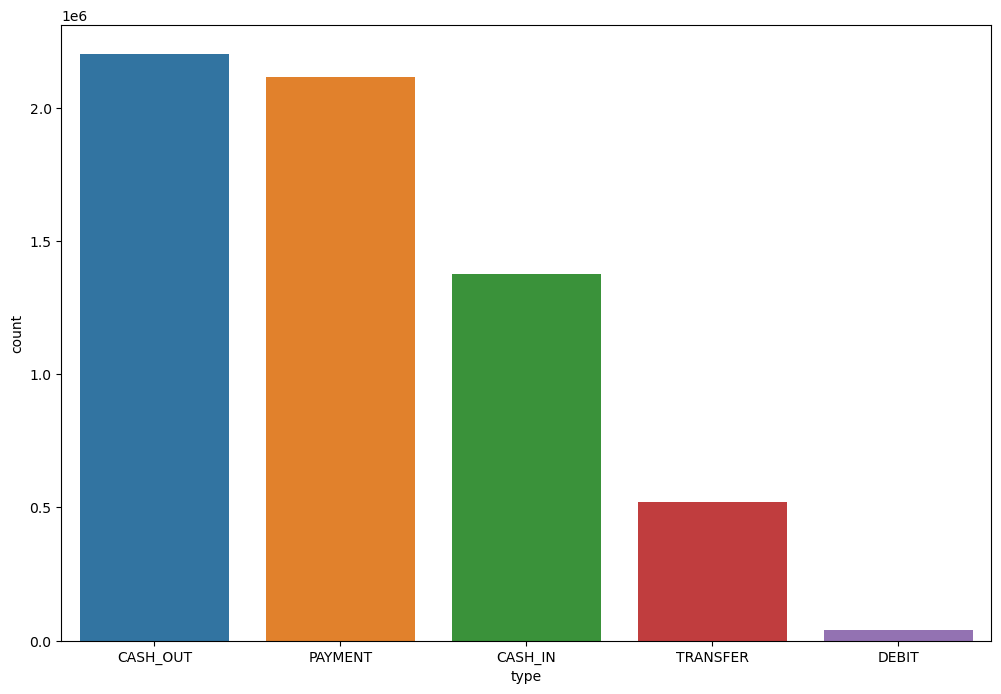

In [ ]:
plt.figure(figsize=(12,8))
print(df_non_fraud['type'].value_counts(normalize = True))

plt.subplot(1,1,1)
sns.countplot(data = df_non_fraud, x = 'type')
plt.show();

#### FALSE: Payment is much less than 50% of non fraudulent transactions

### H3. Customer to Merchant represent at least 50% of the total fraudulent transactions.

C2C   1.00
Name: transaction_direction, dtype: float64


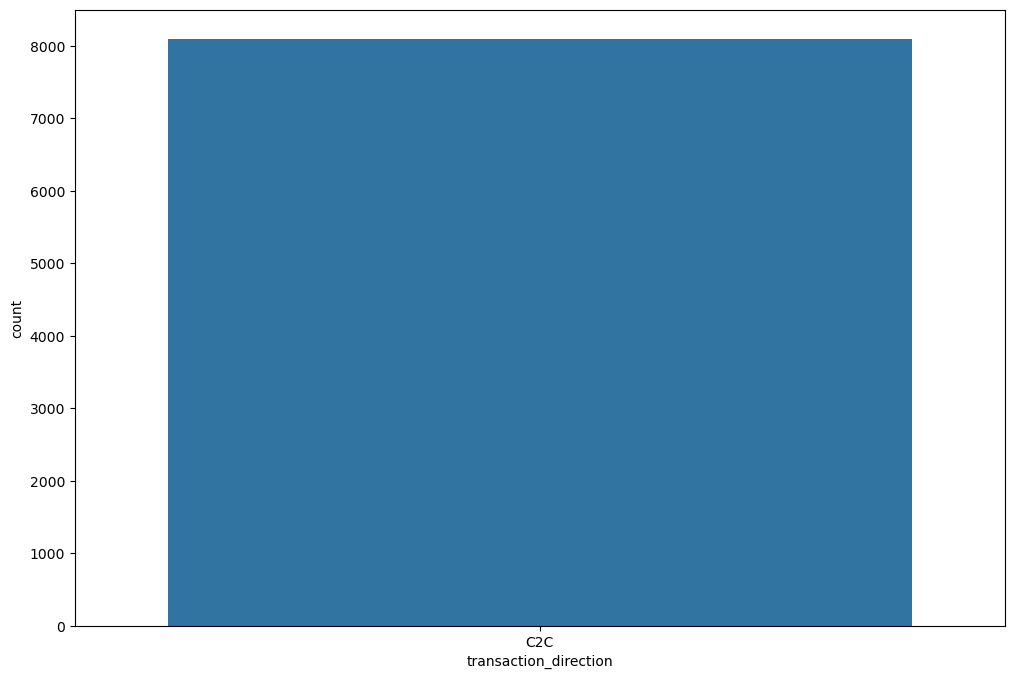

In [ ]:
plt.figure(figsize=(12,8))
print(df_fraud['transaction_direction'].value_counts(normalize = True))

plt.subplot(1,1,1)
sns.countplot(data = df_fraud, x = 'transaction_direction')

plt.show();

#### FALSE: In fraudulent transactions, only C2C is present (100%)

### H4. Customer to Customer represent at least 50% of the total non fraudulent transactions.

C2C   0.66
C2M   0.34
Name: transaction_direction, dtype: float64


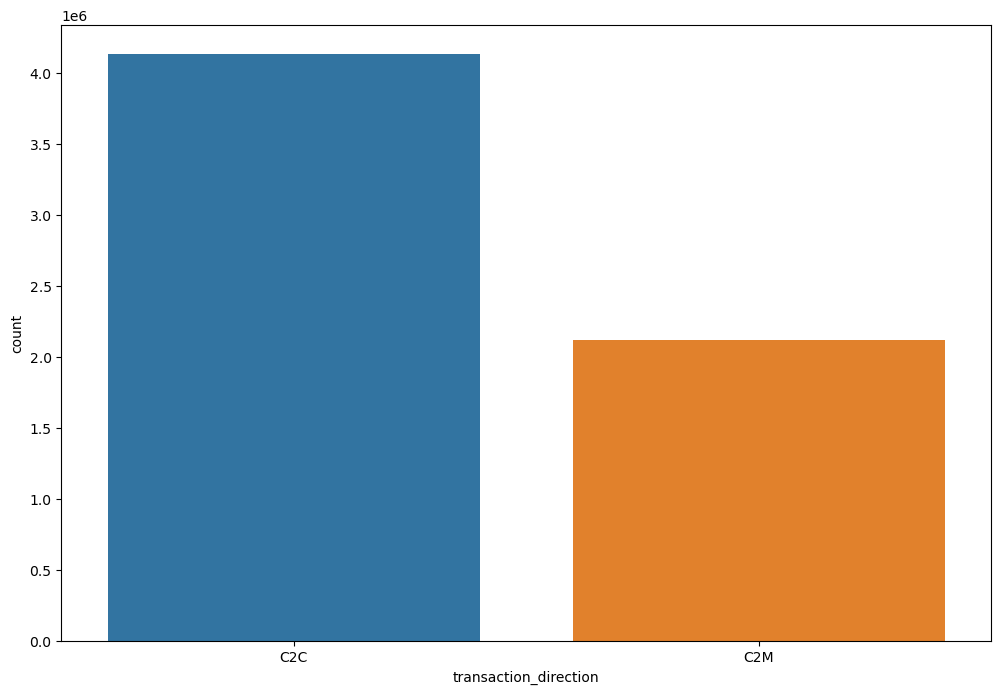

In [ ]:
plt.figure(figsize=(12,8))
print(df_non_fraud['transaction_direction'].value_counts(normalize = True))

plt.subplot(1,1,1)
sns.countplot(data = df_non_fraud, x = 'transaction_direction')

plt.show();

#### TRUE: C2C in non fraudulent transactions has 66%

### H5. Merchant destination represents 40% of the total fraudulent transactions.

customer   1.00
Name: dest_type, dtype: float64


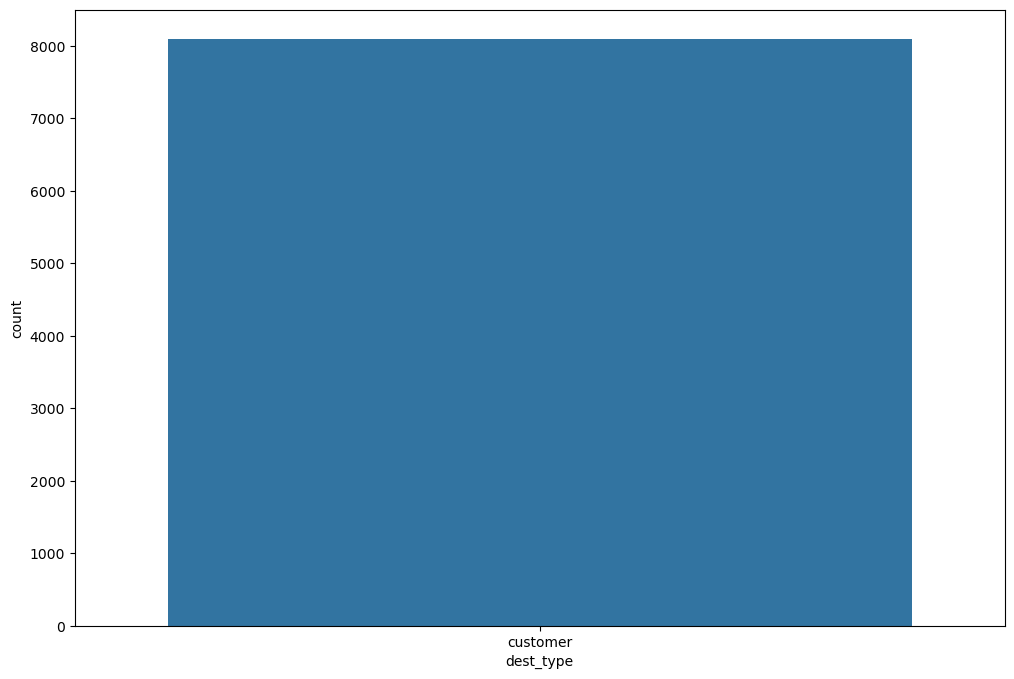

In [ ]:
plt.figure(figsize=(12,8))
print(df_fraud['dest_type'].value_counts(normalize = True))

plt.subplot(1,1,1)
sns.countplot(data = df_fraud, x = 'dest_type')

plt.show();

#### FALSE: Customer represents 100% of the type of destination

### H6. Customer destination represents 40% of the total non fraudulent transactions.

customer   0.66
machine    0.34
Name: dest_type, dtype: float64


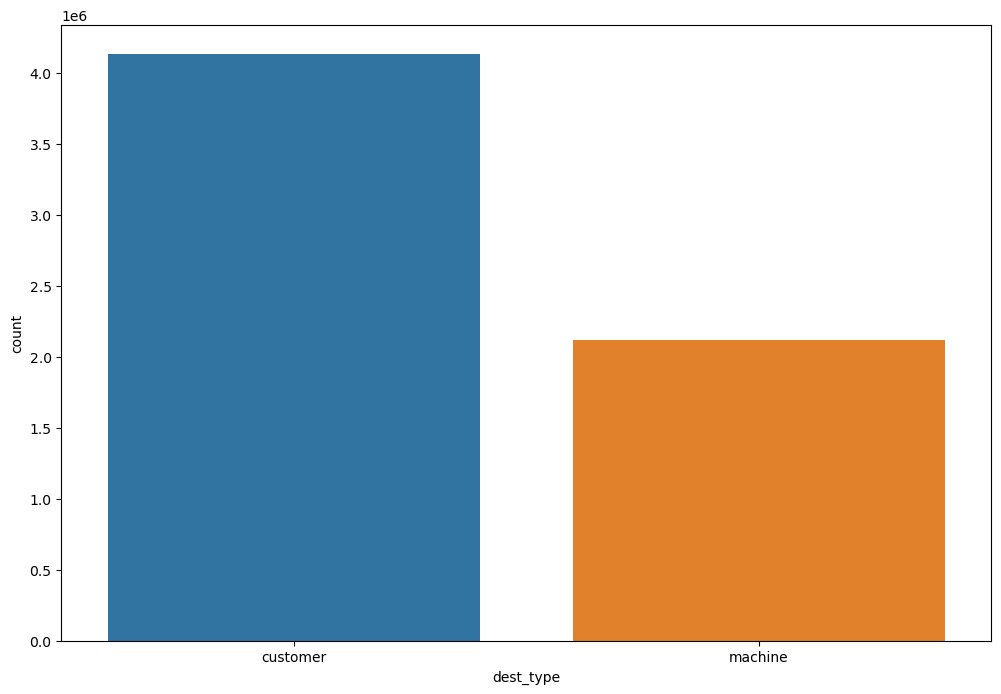

In [ ]:
plt.figure(figsize=(12,8))
print(df_non_fraud['dest_type'].value_counts(normalize = True))

plt.subplot(1,1,1)
sns.countplot(data = df_non_fraud, x = 'dest_type')

plt.show();

#### FALSE: Customer destination of non fraudulent represents ~66%

### H7. Destination non zero new balance represents 50% of the total fraudulent transactions.

non zero   0.50
zero       0.50
Name: new_balance_dest_status, dtype: float64


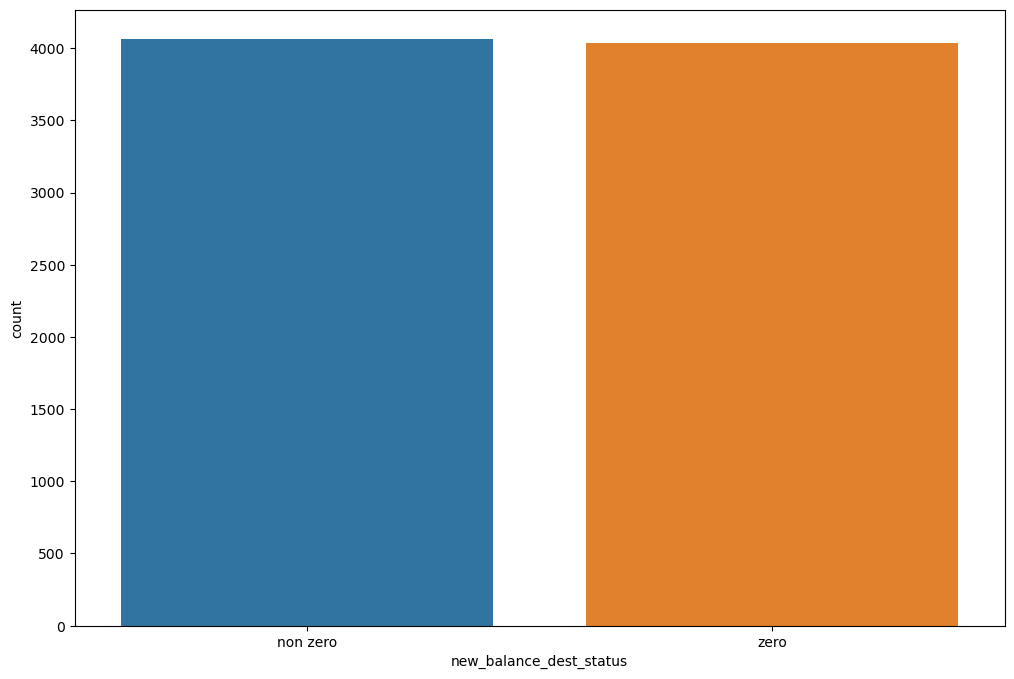

In [ ]:
plt.figure(figsize=(12,8))
print(df_fraud['new_balance_dest_status'].value_counts(normalize = True))

plt.subplot(1,1,1)
sns.countplot(data = df_fraud, x = 'new_balance_dest_status')

plt.show();

#### TRUE: Destination balance with non zero represents 50% of all fraudulent transactions

### H8. Origin non zero old balance represents 80% of the total fraudulent transactions.


non zero   1.00
zero       0.00
Name: old_balance_orig_status, dtype: float64


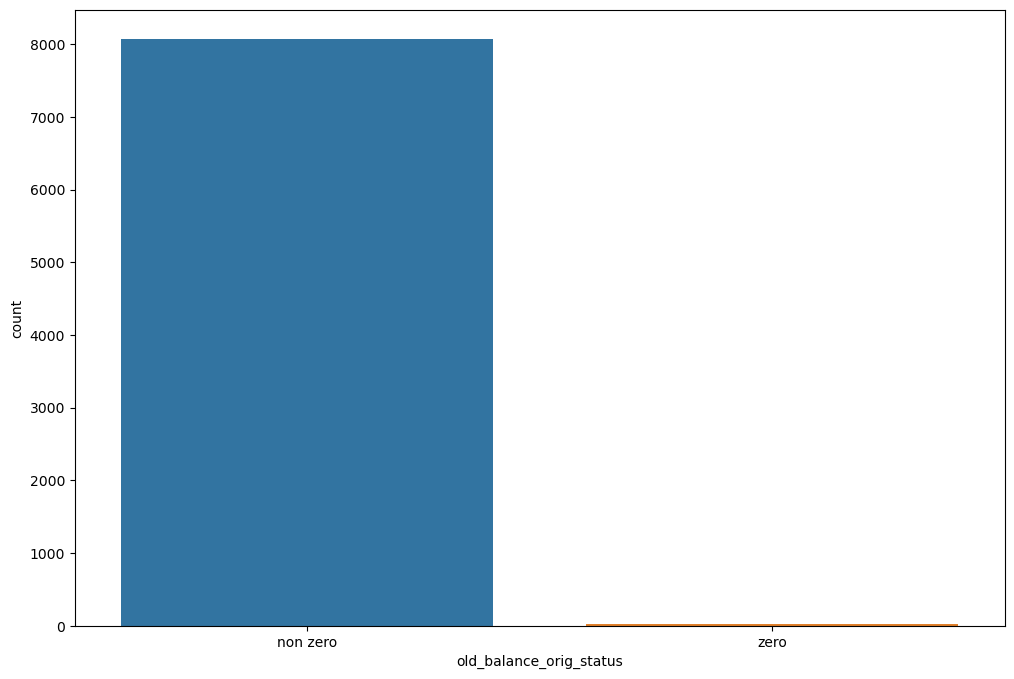

In [ ]:
plt.figure(figsize=(12,8))
print(df_fraud['old_balance_orig_status'].value_counts(normalize = True))

plt.subplot(1,1,1)
sns.countplot(data = df_fraud, x = 'old_balance_orig_status')

plt.show();

#### FALSE: non zero old balance origin represents almost 100%

### H9. Origin zero new balance represents 40% of the total fraudulent transactions.

zero       0.98
non zero   0.02
Name: new_balance_orig_status, dtype: float64


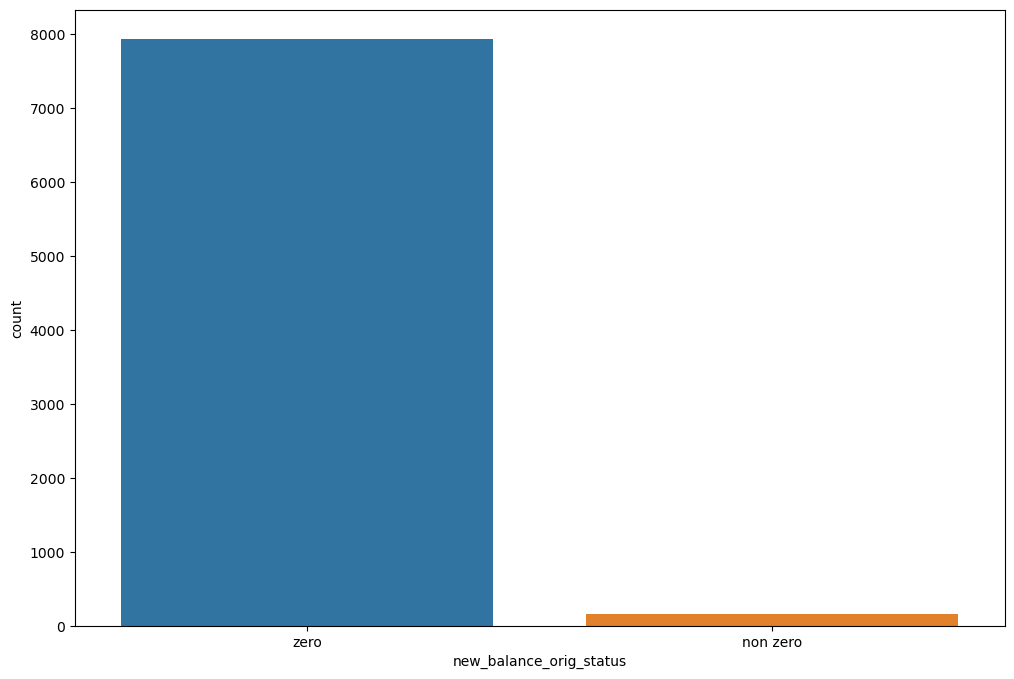

In [ ]:
plt.figure(figsize=(12,8))
print(df_fraud['new_balance_orig_status'].value_counts(normalize = True))

plt.subplot(1,1,1)
sns.countplot(data = df_fraud, x = 'new_balance_orig_status')

plt.show();

#### FALSE: origin new balance status ZERO represents almost 100%

### H10. At least 95% of the total fraudulent transactions are flagged as fraud.

0   1.00
1   0.00
Name: isFlaggedFraud, dtype: float64


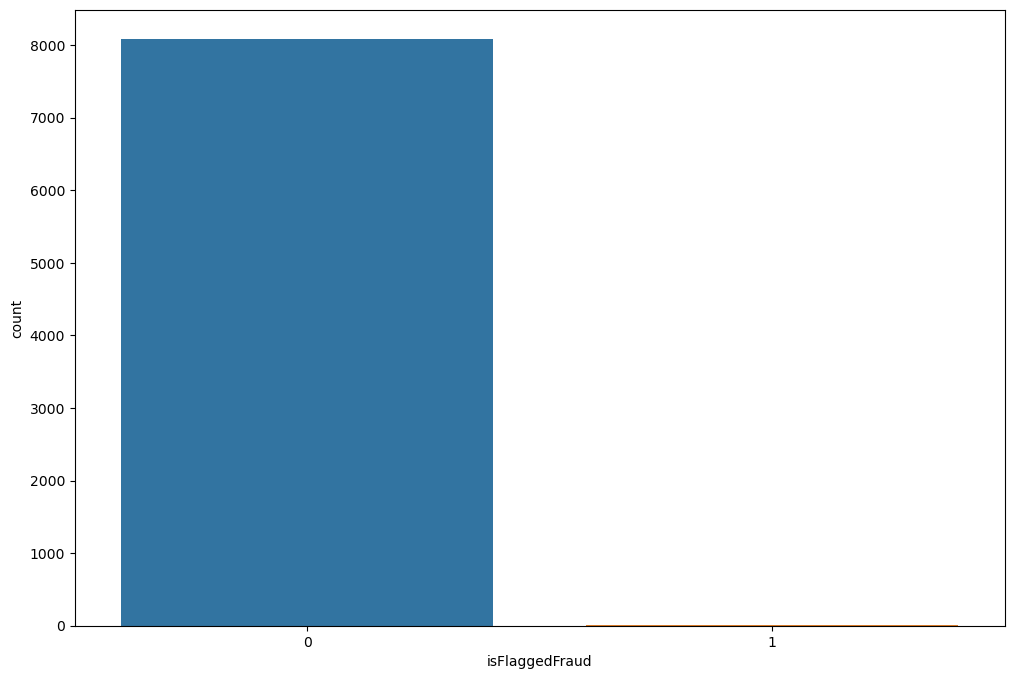

In [ ]:
plt.figure(figsize=(12,8))
print(df_fraud['isFlaggedFraud'].value_counts(normalize = True))

plt.subplot(1,1,1)
sns.countplot(data = df_fraud, x = 'isFlaggedFraud')

plt.show();

#### FALSE: isFlaggedFraud is almost 100%, not 95%

### H11. At least 20% of the total non fraudulent transactions are flagged as fraud.

0   1.00
Name: isFlaggedFraud, dtype: float64


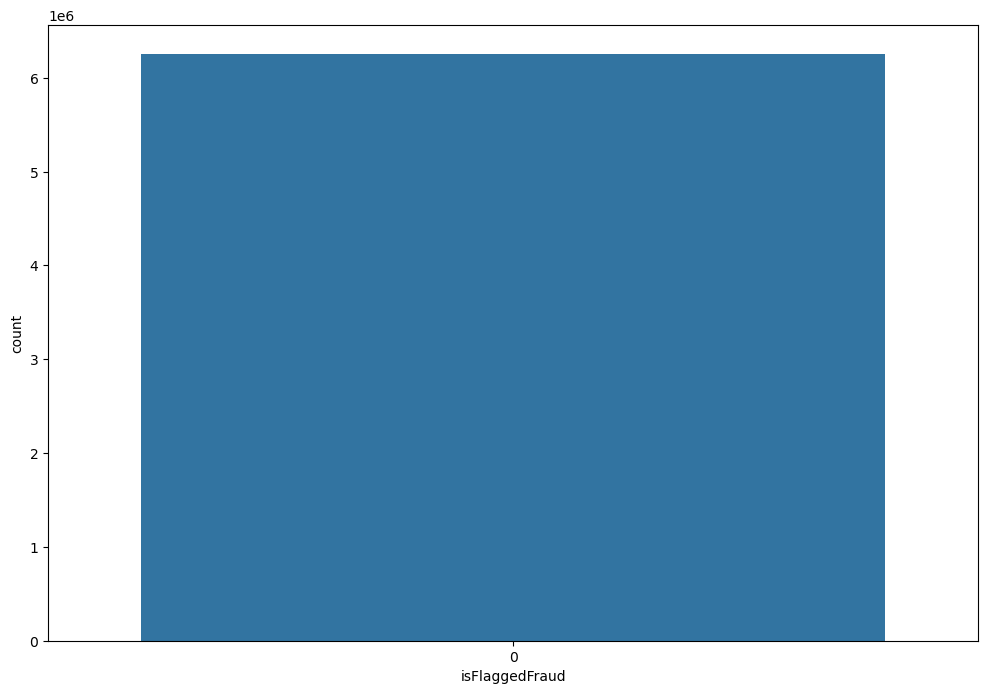

In [ ]:
plt.figure(figsize=(12,8))
print(df_non_fraud['isFlaggedFraud'].value_counts(normalize = True))

plt.subplot(1,1,1)
sns.countplot(data = df_non_fraud, x = 'isFlaggedFraud')

plt.show();

#### FALSE: almost 100% of all transactions are flagged as non fraud

### Hypothesis Summary

| ID  | Hypothesis                                                                                 | Conclusion |
|:-----:|:-----------------------------------------------------------------------------------------|:------------|
| H1  |Payment represent 50% of the total fraudulent transactions.                                 | FALSE|
| H2  |Transfer represent 50% of the total non fraudulent transactions.                            | FALSE|
| H3  |Customer to Merchant represent at least 50% of the total fraudulent transactions.           | FALSE|
| H4  |Customer to Customer represent at least 50% of the total non fraudulent transactions.       | TRUE|
| H5  |Merchant destination represents 40% of the total fraudulent transactions.                   | FALSE|
| H6  |Customer destination represents 40% of the total non fraudulent transactions.               | FALSE|
| H7  |Destination non zero new balance represents 50% of the total fraudulent transactions.       | TRUE|
| H8  |Origin non zero old balance represents 80% of the total fraudulent transactions.            | FALSE|
| H9  |Origin zero new balance represents 40% of the total fraudulent transactions.                | FALSE|
| H10  |At least 95% of the total fraudulent transactions are flagged as fraud.                    | FALSE|
| H11  |At least 20% of the total non fraudulent transactions are flagged as fraud.                | FALSE|

## Multivariate Analysis

In [ ]:
df_fraud.head(3)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,orig_type,dest_type,old_balance_orig_status,new_balance_orig_status,old_balance_dest_status,new_balance_dest_status,is_orig_old_balance_greater_new,is_dest_old_balance_greater_new,transaction_direction,is_orig_equal_dest,hour
271,596,CASH_OUT,381247.30,C611134778,381247.30,0.00,C686935058,392496.79,773744.09,1,0,customer,customer,non zero,zero,non zero,non zero,no,yes,C2C,no,19
3530,596,TRANSFER,196385.55,C959692250,196385.55,0.00,C665462756,0.00,0.00,1,0,customer,customer,non zero,zero,zero,zero,no,yes,C2C,no,19
4521,596,TRANSFER,204721.27,C1892500400,204721.27,0.00,C517910337,0.00,0.00,1,0,customer,customer,non zero,zero,zero,zero,no,yes,C2C,no,19


In [ ]:
# gets the numerical attributes
numerical_att = df2[['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig','oldbalanceDest', 'newbalanceDest']]

# gets the categorical attributes
cat_att = df2[['type','nameOrig', 'nameDest', 'orig_type', 'dest_type', 'transaction_direction']].copy()
cat_att = cat_att.astype(str)

# gets binary attributes
binary_att = df2[['isFlaggedFraud', 'old_balance_orig_status', 'new_balance_orig_status', 'old_balance_dest_status',
                       'new_balance_dest_status', 'is_orig_equal_dest','is_orig_old_balance_greater_new', 'is_dest_old_balance_greater_new']]

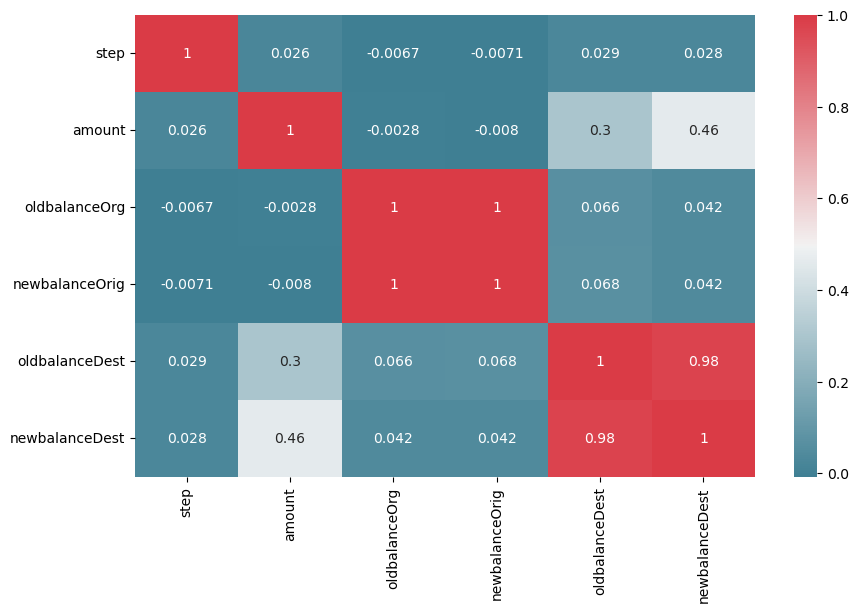

In [ ]:
num_corr = numerical_att.corr()

fig, axes = plt.subplots(1,1,figsize=(10,6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(num_corr, ax = axes, cmap=cmap, annot = True);

In [ ]:
# instantiates a profile report
profile = ProfileReport(cat_att, title="Pandas Profiling Report for categorical attributes")

# saves report to a html file
profile.to_file("categorical_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

![](img/pp_categorical_warnings.png)

As observed, we have values that are constant, have high cardinality and high correlated with each other. Thus, this tells us:

- **Constant value:** we can drop this feature as this won't aggregate any information for our ML model.
- **High cardinality:** we need to choose the most appropriate categorical encoding strategy.
- **High correlation:** we can drop some features and keep other in order to remove colinearity.
- **Uniform:** we need to keep an eye on this because it can mean the presence of a **high cardinality**.

#### Cramér's V - categorical correlations

![](img/pp_categorical_correlations.png)

As observed, all the categorical attributes presents perfect positive correlations with each other. This means we'll need to drop some of them while keeping others.